# Vietnamese OCR with transformer

Install các thư viện cần thiết

In [1]:
# ! pip install --quiet vietocr==0.3.2

In [2]:
# ! pip install einops

# Predict Image

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

import editdistance
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
config = Cfg.load_config_from_name('vgg_transformer')

Đường dẫn cho model của bạn hoặc lấy model đã train sẵn qua drive URL

In [3]:
# config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
config['weights'] = '../model/model.pth'
config['device'] = 'cpu' # device để huấn luyện mô hình, để sử dụng cpu huấn luyện thì thay bằng 'cpu'

In [4]:
detector = Predictor(config)

In [26]:
def loss_score(y_predict, y_label):
    CER = []
    WER = []
    length_y = len(y_label)
    for key, value in y_label.items():                  
        CER.append(editdistance.eval(y_predict[key] ,value)/len(value))
        WER.append(editdistance.eval(y_predict[key].split(" ") ,value.split(" "))/len(value))
    CER = sum(CER)/length_y
    WER = sum(WER)/length_y    
    return CER, WER

In [27]:
import json 

test_labels = json.load(open('../labels/labels_test.json'))
predict = {}

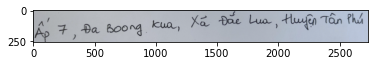

In [5]:
img = '../test/Screen Shot 2021-06-20 at 11.11.22.png'
img = Image.open(img)
plt.imshow(img)
test = detector.predict(img)

In [6]:
test

'Áp 7, Đa Boong, Kua, Xã Đắc Lua, Huyện Tân Phú'

In [11]:
# for key, item in test_labels.items():
#     img_path = "../private_test/" + key
#     img = Image.open(img_path)
#     predict[key] = detector.predict(img)

In [20]:
# import json

# with open('../predict/predict_transformer.json', 'w') as fp:
#     json.dump(predict, fp, ensure_ascii=False)

In [28]:
with open('../predict/predict_transformer.json', 'r') as j:
     contents = json.loads(j.read())

In [29]:
loss_score = loss_score(contents, test_labels)

In [35]:
print("Character Error Rate (CER): "+ str(loss_score[0]))
print("Word Error Rate (WER): "+ str(loss_score[1]))

Character Error Rate (CER): 0.2309717961880506
Word Error Rate (WER): 0.12867499687160128


# Train Model

In [2]:
from vietocr.tool.config import Cfg
from vietocr.model.trainer import Trainer

In [3]:
config = Cfg.load_config_from_name('vgg_transformer')

# Config các tham số model 
* *data_root*: Thư mục chứa data ảnh
* *train_annotation*: Nhãn chứa label ở tập train
* *valid_annotation*: Nhãn chứa label ở tập test
* *print_every*: In ra loss score ở quá trình train ở lần train thứ k
* *valid_every*: In ra loss score ở quá trình validation ở lần train thứ k
* *iters*: Số lần training cho model
* *export*: Thư mục lưu model 
* *metrics*: Số ảnh dùng để validation 

In [6]:
dataset_params = {
    'name':'hw', # tên dataset mà bạn tự đặt
    'data_root':'./mydata/', # Folder chứa folder ảnh và nhãn 
    'train_annotation':'train_text.txt', # Đường dẫn của ảnh để train và nhãn tương ứng dùng
    'valid_annotation':'test_text.txt'   # Đường dẫn của ảnh để đánh giá và nhãn tương ứng dùng
}

params = {
         'print_every':5,  # hiển thị loss mỗi 5 iteration 
         'valid_every': 5, # hiển thị loss mỗi 5 iteration 
          'iters': 50,     # Huấn luyện 50 lần
          'checkpoint':'./checkpoint/transformerocr_checkpoint.pth', ## lưu model checkpoint tại folder này   
          'export':'./weights/transformerocr.pth', # lưu model được huấn luyện tại folder này
          'metrics': 25    # sử dụng 25 ảnh của tập test để đánh giá mô hình
         }

config['trainer'].update(params)
config['dataset'].update(dataset_params)
config['device'] = 'cpu'
config['dataloader'] ={'num_workers':0, 'pin_memory': True}

# Huấn luyện mô hình từ pretrained model sẵn sẽ nhanh hội tụ và cho kết quả tốt hơn khi bạn chỉ có bộ dataset nhỏ

In [9]:
trainer = Trainer(config, pretrained=True)

Create train_hw: 100%|█████████████████████████████████████████| 1458/1458 [00:05<00:00, 249.97it/s]


Created dataset with 1457 samples


Create valid_hw: 100%|█████████████████████████████████████████| 1458/1458 [00:04<00:00, 295.30it/s]


Created dataset with 1457 samples


valid_hw build cluster: 100%|███████████████████████████████| 1457/1457 [00:00<00:00, 109197.00it/s]


# Visualize tập train, bao gồm cả augmentation 

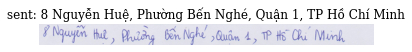

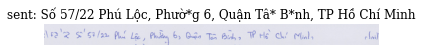

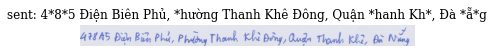

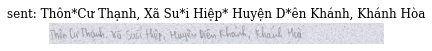

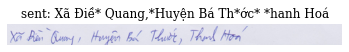

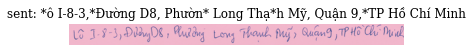

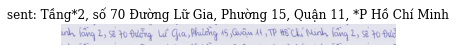

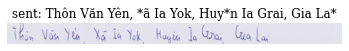

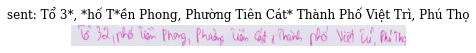

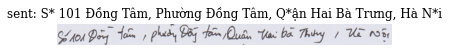

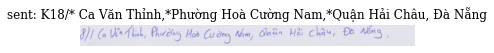

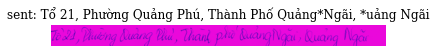

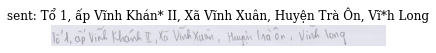

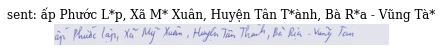

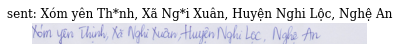

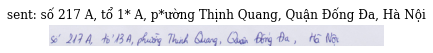

In [10]:
trainer.visualize_dataset()

# Save config của bạn cho lần sau huấn luyện tiếp 

In [11]:
# trainer.config.save('config.yml')

# Bắt đầu train mô hình

In [1]:
trainer.train()

# Save lại model khi bạn muốn break trong quá trình train

In [ ]:
# trainer.save_weights('weights/model.pth')